In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create `Field2D` class

Simplest field possible. Use as a blueprint for more complicated (network-based) classes.

In [2]:
class Field2D():
    # create a 2D grid to find weights and distances on

    cost_est = None
    weights = None 
    res = 1

    def __init__(self, xsize, ysize, init_cost=10, res=1):
        '''
        initialize cost estimate grid and weight grid
        '''
        # TODO: tweakable resolution?
        self.cost_est = np.ones([xsize, ysize])*init_cost
        self.weights = np.ones([xsize, ysize])
        self.res = res
    
    def get_dist(self, loc1, loc2):
        '''
        get distance between two locs
        '''
        return ((loc2[0] - loc1[0])**2 + (loc2[1] - loc1[1])**2)**(1/2)
    
    def cmask(self, loc, radius):
        '''
        get all IDs within the given radius (after normalization to indices) of loc
        '''
        radius_normalized = radius/self.res
        a,b = loc
        nx,ny = self.weights.shape
        y,x = np.ogrid[-a:nx-a,-b:ny-b]
        x,y = np.where(x*x + y*y <= radius_normalized*radius_normalized)
        return set([(x[i],y[i]) for i in range(len(x))])
    
    def set_loc(self, loc, cost_est=None, weight=None):
        '''
        set the cost estimate and weight at a location to new values
        '''
        pass

        if cost_est:
            self.cost_est[loc] = cost_est
        if weight:
            self.weights[loc] = weight

## test Field2D

In [3]:
testfield = Field2D(10,10)
print(testfield.get_dist((0,0),(0,10)))
print(testfield.get_dist((0,0),(10,0)))
print(testfield.get_dist((0,0),(10,10)))

10.0
10.0
14.142135623730951


In [4]:
a = lambda x,y: x+y
a(1,2)

3

# Create `BackhaulEstimator`

Works with any class that follows the `Field2D` prototype.

In [83]:
class BackhaulEstimator:
    # create a prototype that can handle distances in either a 2D grid or a road network
    # concrete implementations of Field need to define a constructor and a _get_dist() function

    __b = 10 # base cost per mile in $/mi

    def __init__(self, field, weight_fcn=(lambda w,d: w/(1+.001*(1-d))), weight_fcn_higher=(lambda w,d: w/(1+.001*(1-d)))):
        # pass an object of the class FieldPrototype or its child classes
        self.field = field
        self.weight_fcn = weight_fcn
        self.weight_fcn_higher = weight_fcn_higher
    
    def __get_radial_area(self, loc, radius):
        '''
        get list of indices that can be used to identify grid locations/nodes and their distance to the loc
        '''

        # get mask
        inner = self.field.cmask(loc, radius)
        outer = self.field.cmask(loc, 2*radius).difference(inner)
        
        # create dict for outer points of their normalized distance from the circle
        outer_dists = {k: (self.field.get_dist(loc, k) - radius)/radius for k in outer}
        
#         # TODO: remove after testing
#         plt.scatter([x[0] for x in inner], [x[1] for x in inner], c='red')
#         plt.scatter([x[0] for x in outer], [x[1] for x in outer], c='orange')
#         plt.ylim(0,self.field.weights.shape[0])
#         plt.xlim(0,self.field.weights.shape[0])
#         plt.show()
        
        return inner, outer, outer_dists
    
    def __update_index(self, loc, cost, accepted, d=0):
        '''
        update estimated cost and weight at a specific index based on a resolved request's cost and acceptance status 
        '''
        c_hat = self.field.cost_est[loc]

        # calc alpha coeff to decay effect outside of inner area.
        # note d is normalized distance outside of inner circle from [0,1]
        alpha = d #(d*self.__b/cost)

        # move estimate toward observed cost if it contains more information
        if accepted or (cost > c_hat):
            movement_factor = alpha*self.field.weights[loc]
            cost_est = (1 - movement_factor)*cost + (movement_factor)*c_hat

            # make current cost estimate stickier
            # TODO: how to update weight properly?
            if accepted:
                weight = self.weight_fcn(self.field.weights[loc],d)
            elif (cost > c_hat):
                # TODO: consider increasing weight less aggressively and cost_est more aggressively
                weight = self.weight_fcn_higher(self.field.weights[loc],d)
            
            # TODO: fix rejection inner weight update
        
            self.field.set_loc(loc, cost_est, weight)
    
    def __get_rec_range(self, loc1, loc2):
        '''
        recommend pricing range that trades off between likelihood of acceptance and gathering additional information
        '''
        # TODO
        range = []
        return range

    def get_cost_est(self, loc1, loc2):
        '''
        calculate estimated cost of delivery with cost of getting to loc1, leaving loc2, and travel dist
        '''
        
        # TODO: factor in cost of getting paid to get closer to depot
        
        cost_estimate = self.field.cost_est[loc1] + self.field.cost_est[loc2] + self.field.get_dist(loc1, loc2)*self.__b
        # calculate price range to offer in order to gain the most information about area. returns length 2 array.
        cost_rec_range = self.__get_rec_range(loc1, loc2)
        return cost_estimate, cost_rec_range

    def update_est(self, loc1, loc2, price, accepted):
        '''
        update estimates in areas affected by new offer resolution
        '''
        cost = (price - self.__b*self.field.get_dist(loc1, loc2))/2
        if cost < 0:
#             print(self.__b*self.field.get_dist(loc1, loc2))
#             print('cost {} shouldn\'t be less than zero. setting cost to 0.1.'.format(cost))
            cost = 0.1

        # get radial areas around loc1 and loc2 and reconcile the overlap
        radius = cost/self.__b
        inner1, outer1, outer_dists1 = self.__get_radial_area(loc1, radius)
        inner2, outer2, outer_dists2 = self.__get_radial_area(loc2, radius)
        inner1.update(inner2)
        inner = inner1
        outer1.update(outer2)
        outer = outer1
        outer.difference_update(inner)

        # merge outer_dists dictionaries, removing entries in inner and taking minimum dist in case of overlap
        outer_dists = {}
        for k in outer:
            dists = []
            if k in outer_dists1:
                dists.append(outer_dists1[k])
            if k in outer_dists2:
                dists.append(outer_dists2[k])
            outer_dists[k] = min(dists)

        # update cost estimate and weights in affected areas
        # TODO: remove after debugging
        for loc in inner:
            self.__update_index(loc, cost, accepted)
#         a = plt.contourf(self.field.weights.T)
#         plt.colorbar(a)
#         plt.title('weights after inner update')
#         plt.show()
#         for loc in outer:
#             self.__update_index(loc, cost, accepted, d=outer_dists[loc])
#         a = plt.contourf(self.field.weights.T)
#         plt.colorbar(a)
#         plt.title('weights after full update')
#         plt.show()
    
    def get_recommended_cost(self, loc1, loc2):
        '''
        convenience function to yield a single price from the estimate and info range
        aiming to maximize the likelihood of a match first, then info gathering
        if est in range, return est
        if est below range, return est
        if est above range, return range high
        '''

        est, range = self.get_cost_est(loc1, loc2)

        if est < range[1]:
            return est
        else:
            return range[1]

## Testing `BackhaulEstimator`

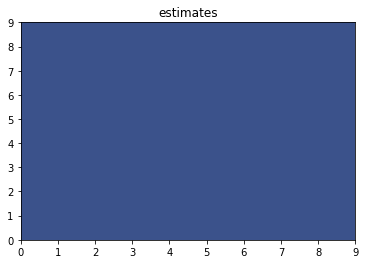

In [6]:
testfield = Field2D(10,10)
be = BackhaulEstimator(testfield)

plt.contourf(testfield.cost_est)
plt.title('estimates')
plt.show()

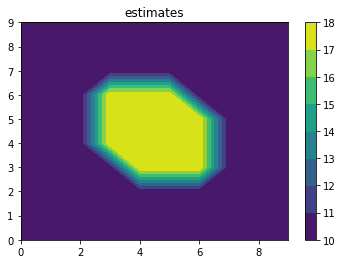

In [7]:
be.update_est((4,5),(5,4),50,True)

a = plt.contourf(testfield.cost_est)
plt.colorbar(a)
plt.title('estimates')
plt.show()

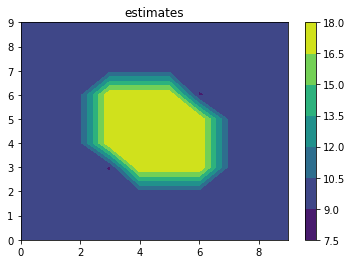

In [8]:
be.update_est((6,6),(3,3),60,True)

a = plt.contourf(testfield.cost_est)
plt.colorbar(a)
plt.title('estimates')
plt.show()

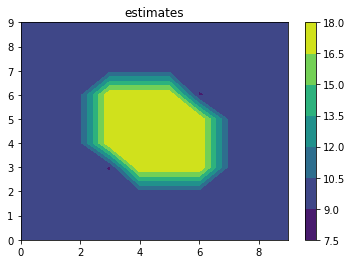

In [9]:
be.update_est((6,3),(3,6),50,False)

a = plt.contourf(testfield.cost_est)
plt.colorbar(a)
plt.title('estimates')
plt.show()

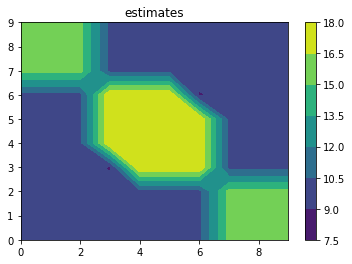

In [10]:
be.update_est((1,8),(8,1),130,False)

a = plt.contourf(testfield.cost_est)
plt.colorbar(a)
plt.title('estimates')
plt.show()

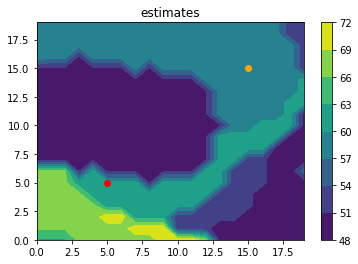

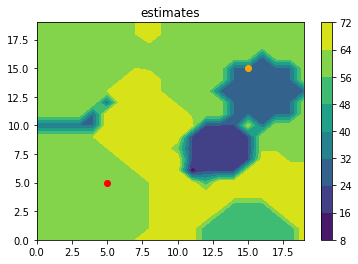

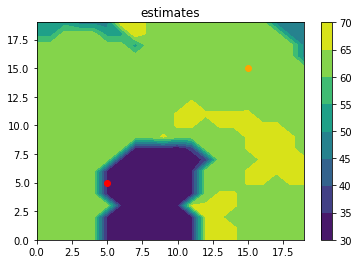

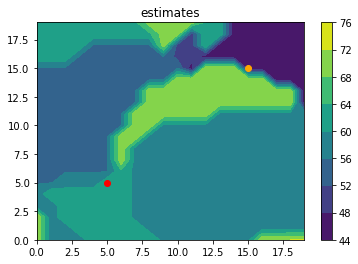

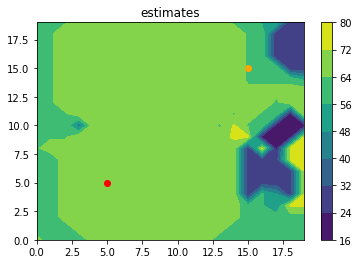

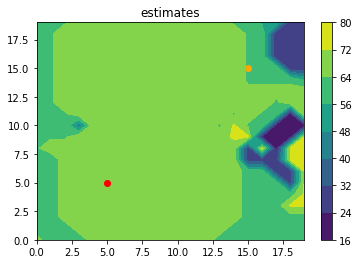

In [84]:
n = 20 # size of field
testfield = Field2D(n,n)
be = BackhaulEstimator(
        testfield, 
        weight_fcn = ( lambda w,d: w/ (1 + ( .0001*(1-d) )) ), 
        weight_fcn_higher= (lambda w,d: w/ (1 + ( .0001*(1-d) )) )
        )

# set original params
ogorg = (15,15)
depot = (5,5)

i = 0 # requests accepted
r = 0 # requests rejected since last reassignment

og = ogorg

while i < 10001:

    # calc current cost to return to depot
    curcost = testfield.get_dist(og, depot)*be._BackhaulEstimator__b

    # randomly generate an OD pair
    rog = (np.random.randint(n), np.random.randint(n))
    rdt = (np.random.randint(n), np.random.randint(n))

    # calculate minimum cost of transporting
    mincost = testfield.get_dist(rog, rdt)*be._BackhaulEstimator__b

    # add random addtl revenue to cover cost of travel
    rev = mincost + (np.random.rand()*(3*n/4) - 1/4)*be._BackhaulEstimator__b

    # calc true cost to fulfill request then return to depot
    ofcost = (testfield.get_dist(og, rog) + testfield.get_dist(rog, rdt) + testfield.get_dist(rdt, depot))*be._BackhaulEstimator__b

    # est cost, offered cost, real cost 
#     print('Estimated, offered, real cost', be.get_cost_est(rog, rdt)[0], rev, ofcost-curcost)

    # check if there's profit for carrier
    if rev > (ofcost - curcost):
        # if so, fulfill request and change current origin
#         print('accepted', rog, rdt, rev)
        be.update_est(rog, rdt, rev, True);
        og = rog
        i += 1
        
#         # plot change to od pair
#         plt.plot([og[0], depot[0]], [og[1], depot[1]])
#         plt.scatter(ogorg[0], ogorg[1], color='orange')
#         plt.scatter(depot[0], depot[1], color='red')
#         plt.ylim(0,n)
#         plt.xlim(0,n)
#         plt.show()
    else: # reject request
#         print('rejected', rog, rdt, rev)
        be.update_est(rog, rdt, rev, False);
        r += 1
        
        # reset trajectory if there have been more than 10 rejected requests
        if r > 5:
            r = 0
            og = ogorg
            
#             # plot graph after return to original OD pair
#             plt.plot([og[0], depot[0]], [og[1], depot[1]])
#             plt.scatter(ogorg[0], ogorg[1], color='orange')
#             plt.scatter(depot[0], depot[1], color='red')
#             plt.ylim(0,n)
#             plt.xlim(0,n)
#             plt.show()
    
    
    
    if (i%1000 == 0) and (r == 0):
        a = plt.contourf(testfield.cost_est)
        plt.colorbar(a)
        plt.scatter(ogorg[0], ogorg[1], color='orange')
        plt.scatter(depot[0], depot[1], color='red')
        plt.title('estimates')
        plt.show()

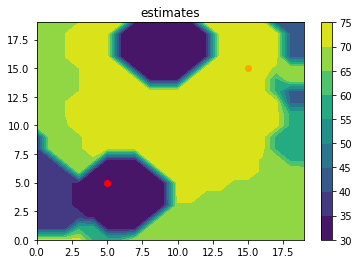

In [80]:
a = plt.contourf(testfield.cost_est)
plt.colorbar(a)
plt.scatter(ogorg[0], ogorg[1], color='orange')
plt.scatter(depot[0], depot[1], color='red')
plt.title('estimates')
plt.show()

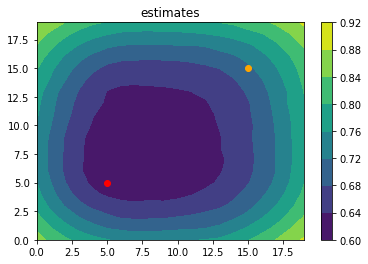

In [81]:
a = plt.contourf(testfield.weights)
plt.colorbar(a)
plt.scatter(ogorg[0], ogorg[1], color='orange')
plt.scatter(depot[0], depot[1], color='red')
plt.title('estimates')
plt.show()